## Import packages

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot

from pybandstructure import *
import graphene as gr
import tqdm
import numpy.linalg as lin

## Graphene and simulation parameters

In [2]:
#distances in nm, energies in eV
#################### band-structure parameters #######################################
k_cutoff = 2. #nm^-1 energies are accurate up to +-hv_F * k_cutoff
q_cutoff = 0.5
hv_F = 0.658  # \hbar v_F in eV*nm
n_sites = 10 # integer 
################### these parameters can be changed later ############################
density = 0. # nm^-2
temperature = 0.026 # eV k_B T
eta = 0.1 # eV energy broadening \hbar/tau 

## Define geometry and sampling of k space

C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\sample\sample.py:584: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


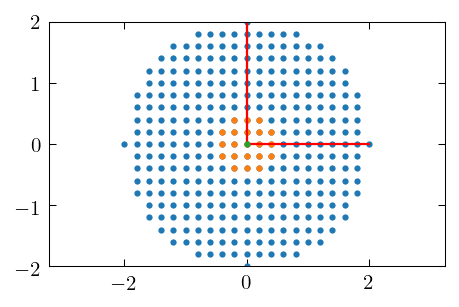

In [3]:
reciprocal_lattice_basis = k_cutoff * np.array([[1.,0.],
                                                  [0.,1.]], dtype = float)
point_group = Point_Group.trivial_group(space_dimension=2)
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                   point_group = point_group)
k_sample = Space_Sample.spherical_sample(basis_vectors = lattice_geometry.reciprocal_lattice_basis, 
                                         denominator = n_sites, 
                                         cut_off = k_cutoff )
q_sample = Space_Sample.spherical_sample(basis_vectors = lattice_geometry.reciprocal_lattice_basis, 
                                         denominator = n_sites, 
                                         cut_off = q_cutoff) 
G_sample = Sample.lattice_sample(basis_vectors=k_sample.basis_vectors, cut_off=0, special_points=None)



k_sample.plot()
q_sample.plot()
G_sample.plot()

## Define Hamiltonian and momentum operators

In [4]:
class f_dirac:
    def __init__(self, hv, der = (0,0)):
        self.hv = hv
        self.der = der
    def __call__(self, k):
        if self.der == (0,0):
            return [self.hv * k[0], self.hv * k[1]]
        if self.der == (1,0):
            return self.hv * np.array([1,0])
        if self.der == (0,1):
            return self.hv * np.array([0,1])
        else:
            return np.array([0,0])

H = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                 coefficients = [f_dirac(hv = hv_F, der =(0,0))]) 
p_x = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                   coefficients =[f_dirac(hv = hv_F, der =(1,0))])
p_y = Momentum_Conserving_Operator(matrices = [[pauli_matrix('x'), pauli_matrix('y')]],
                                   coefficients = [f_dirac(hv = hv_F, der =(0,1))])
#G=0 case
density_operator = [Operator(matrices=[pauli_matrix(0)], coefficients=[lambda k,q: 1], collapse=True, hermitian=True,momentum_conserving = False)]
for i in range(len(G_sample)-1):
    density_operator.append(Operator(matrices=[pauli_matrix(0)], coefficients=[lambda k,q: 0], collapse=True, momentum_conserving = False,hermitian=True))

## Calculate band structure

In [5]:
####################### Output folder ##################################
output_folder = 'test_output/single_layer_dirac'
file_name = '/single_layer_dirac.hdf5'
########################################################################
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
try:
    os.remove(output_folder + file_name)
except:
    pass

band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                     q_sample = q_sample,
                                                     G_sample = G_sample, 
                                                     density_operator=density_operator,
                                                     hamiltonian = H, 
                                                     momentum_operator= [p_x,p_y],
                                                     degeneracy = 4,
                                                     zero_filling = 1,
                                                     density = density,
                                                     temperature = temperature)

band_structure.compute_bands()
band_structure.compute_momentum_matrix()
band_structure.compute_density_matrix()
band_structure.save(file_name = output_folder + file_name, band_structure_name = 'band_structure')
graphene = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure, 
                   eta = eta)

#TEST LOADING FROM FILE
band_structure_loaded = Band_Structure.from_file(file_name = output_folder + file_name, band_structure_name = 'band_structure')
graphene_loaded = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure_loaded, 
                   eta = eta)

100%|███████████████████████████████████████████████████████████████████████████████| 317/317 [00:00<00:00, 734.84it/s]
C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\band_structure\band_structure.py:927: UserWarning: 720 k+q vectors out of 6657 do not have an equivalent in k_sample 
  warn("{} k+q vectors out of {} do not have an equivalent in k_sample ".format(count, n_k_points * n_q_points))


Space_Sample
Space_Sample
Sample


In [6]:
#FROM HAMILTONIAN
graphene.band_structure.chemical_potential = .5
graphene.band_structure.temperature = 0.001
graphene.eta = 0.1
#FROM FILE
graphene_loaded.band_structure.chemical_potential = .5
graphene_loaded.band_structure.temperature = 0.001
graphene_loaded.eta = 0.1

C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\band_structure\band_structure.py:609: UserWarning: changing chemical potential 
                         without changing band structure
  without changing band structure"""
C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\band_structure\band_structure.py:594: UserWarning: changing temperature without changing band structure
  warn("changing temperature without changing band structure")


In [7]:
##TESTING SAVING AND LOADING PROCEDURE
# samples
print(type(graphene_loaded.band_structure._G_sample))
print(type(graphene.band_structure._G_sample))
np.allclose(graphene_loaded.band_structure.G_sample._coords,graphene.band_structure.G_sample._coords)

#k_plus_q_ind table 
print(hasattr(graphene_loaded.band_structure, '_k_plus_q_ind'))
print(np.allclose(graphene_loaded.band_structure._k_plus_q_ind ,graphene.band_structure._k_plus_q_ind))
print(graphene_loaded.band_structure._k_plus_q_ind.shape)

<class 'pybandstructure.sample.sample.Sample'>
<class 'pybandstructure.sample.sample.Sample'>
True
True
(21, 317)


C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff
C:\Users\Windows\anaconda3\lib\site-packages\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


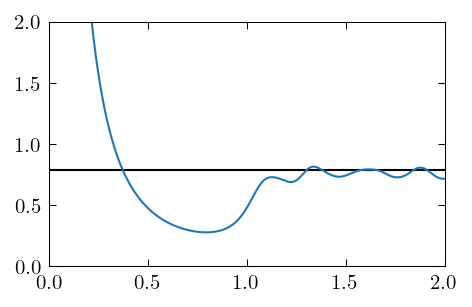

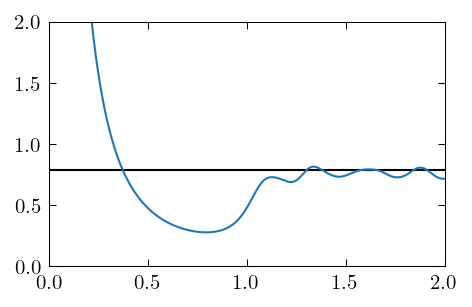

In [8]:
omega_vals = np.linspace(eta,2.,num=500)

sigma_vals = graphene.local_conductivity(omega_vals)[:,0,0]
plt.figure(1)
plt.ylim(0,2)
plt.plot([0,2],[0,0],lw=0.5,c='k')
plt.plot([0,2],[np.pi/4,np.pi/4],c='k')
plt.plot(omega_vals,sigma_vals.real)


#PLOTTING THE FROM FILE RESULT
omega_vals = np.linspace(eta,2.,num=500)
sigma_vals = graphene_loaded.local_conductivity(omega_vals)[:,0,0]
plt.figure(2)
plt.ylim(0,2)
plt.plot([0,2],[0,0],lw=0.5,c='k')
plt.plot([0,2],[np.pi/4,np.pi/4],c='k')
plt.plot(omega_vals,sigma_vals.real)
#something happens when saving and reloading

In [9]:
q_ind = 1
chi_vals = np.zeros(len(omega_vals), dtype =complex)
chi_vals_loc = ((sigma_vals/omega_vals)
                *(-1.j/np.pi)
                *(lin.norm(graphene.band_structure.q_sample.get_coords(q_ind)))**2)

chi_vals = graphene.polarization(omega_vals + 1j*np.ones(len(omega_vals))*graphene.eta,q_ind,0,0)

chi_exact = gr.chi(omega = omega_vals,
       q = lin.norm(graphene.band_structure.q_sample.get_coords(q_ind)),
       Ef = graphene.band_structure.chemical_potential)

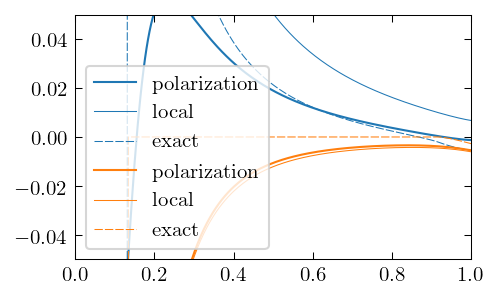

In [10]:
_ = plt.plot(omega_vals,chi_vals.real, label='polarization')
plt.plot(omega_vals,chi_vals_loc.real,c = _[0].get_color(),lw = 0.5, label='local')
plt.plot(omega_vals, chi_exact.real,'--',c = _[0].get_color(),lw = 0.5, label='exact')
_ = plt.plot(omega_vals,chi_vals.imag, label='polarization')
plt.plot(omega_vals,chi_vals_loc.imag,c = _[0].get_color(),lw = 0.5, label='local')
plt.plot(omega_vals, chi_exact.imag,'--',c = _[0].get_color(),lw = 0.5, label='exact')

#plt.plot([hv_F*lin.norm(graphene.band_structure.q_sample.get_coords(q_ind)),
#          hv_F*lin.norm(graphene.band_structure.q_sample.get_coords(q_ind))]
#         ,[-1,1], 'k',lw=0.5)
plt.xlim(0,1.0)
plt.ylim(-0.05,0.05)
plt.legend()

In [11]:
a = np.zeros([2,500])
for i in tqdm.tqdm(range(2)):
    q_ind = q_sample[(i,0)]
    a[i,:] = -np.imag(graphene.polarization(omega_vals,q_ind,0,0))


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 71.43it/s]


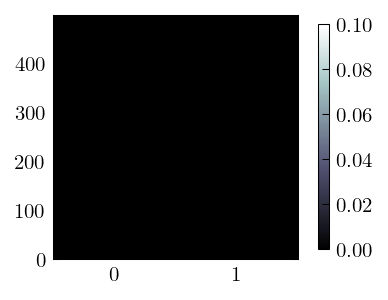

In [12]:
#plt.imshow(a.T,vmin=0,vmax=1e-1)
plt.imshow(a.T, interpolation='nearest', cmap='bone', origin='lower',vmin=0,vmax=1e-1)
plt.colorbar(shrink=.92)
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())

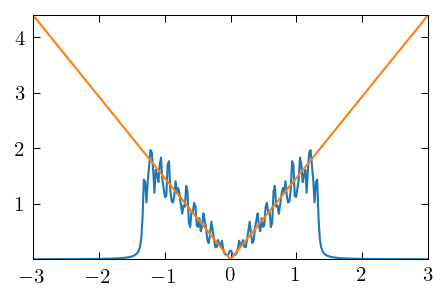

In [13]:
z = np.linspace(-3,3, num=300)
graphene.eta=0.02
plt.plot(z, graphene.dos(z))
plt.plot(z, abs(z)*2/(np.pi * hv_F**2))

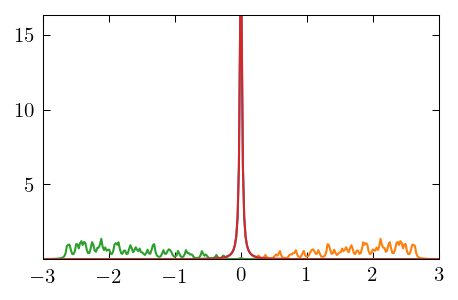

In [14]:
plt.plot(z, graphene.jdos(z,0,0))
plt.plot(z, graphene.jdos(z,1,0))
plt.plot(z, graphene.jdos(z,0,1))
plt.plot(z, graphene.jdos(z,1,1))